/tmp/ipykernel_16968/582229696.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(self.X, dtype=torch.float32)


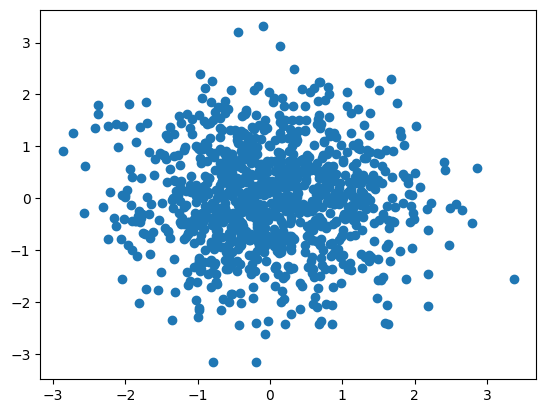

/tmp/ipykernel_16968/582229696.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(self.X, dtype=torch.float32)


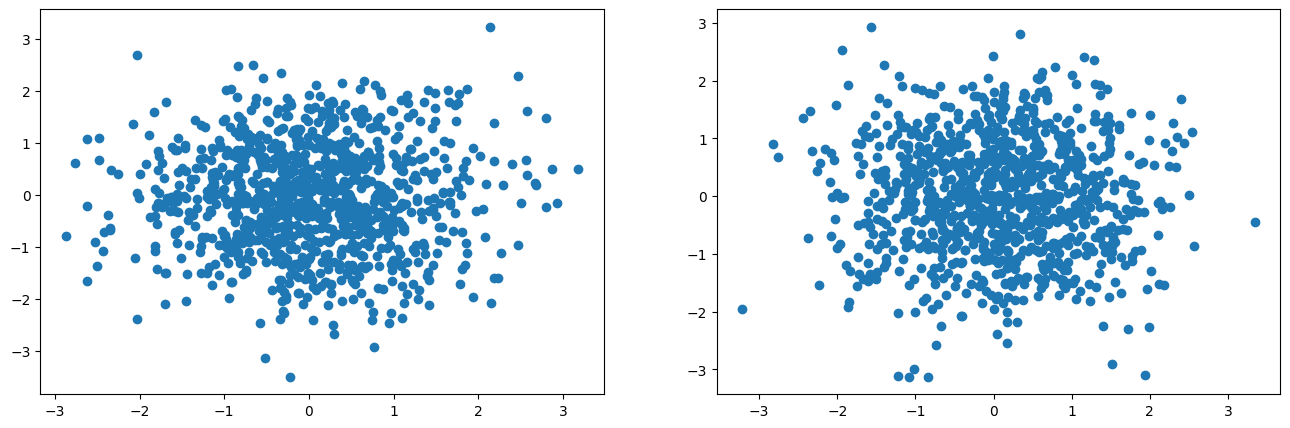

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
class TwoMoons:
    """
    Two moons dataset for testing.
    """

    def __init__(self, n_samples=10000, noise=0.04):
        from sklearn.datasets import make_moons

        self.n_samples = n_samples
        self.noise = noise
        # debug:
        # self.X, _ = torch.randn(n_samples, 2), None
        self.X, _ = make_moons(n_samples=self.n_samples, noise=self.noise)
        self.X = torch.tensor(self.X, dtype=torch.float32)
        
    def loader(self, batch=1000):
        dataset = TensorDataset(self.X)
        return DataLoader(dataset, batch_size=batch, shuffle=True)

def visualize(points):
    assert isinstance(points, torch.Tensor), "points should be a torch tensor"
    assert points.ndim == 2 and points.shape[1] == 2, "points should be a 2D tensor with shape (n_samples, 2)"
    import matplotlib.pyplot as plt
    plt.close()
    plt.scatter(points[:, 0].numpy(), points[:, 1].numpy())
    plt.show()

def vis_compare(points1, points2):
    import matplotlib.pyplot as plt
    plt.close()
    assert isinstance(points1, torch.Tensor) and isinstance(points2, torch.Tensor), "points should be torch tensors"
    assert points1.ndim == 2 and points1.shape[1] == 2, "points1 should be a 2D tensor with shape (n_samples, 2)"
    assert points2.ndim == 2 and points2.shape[1] == 2, "points2 should be a 2D tensor with shape (n_samples, 2)"
    # left-right: two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    ax1.scatter(points1[:, 0].numpy(), points1[:, 1].numpy())
    ax2.scatter(points2[:, 0].numpy(), points2[:, 1].numpy())
    # ax1.set_title("points1")
    # ax2.set_title("points2")
    plt.show()

visualize(TwoMoons().X[:1000])
vis_compare(TwoMoons().X[:1000], TwoMoons().X[1000:2000])

In [2]:
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from functools import partial

class PosEmbedding(nn.Module):
    def __init__(self, dim, N=10000):
        super(PosEmbedding, self).__init__()
        assert dim % 2 == 0, "dim should be even"
        self.register_buffer("angles", N ** (-torch.arange(0, dim, 2, dtype=torch.float32) / dim))
    
    def forward(self, pos):
        assert pos.ndim == 1, f'{pos.shape} should be 1D'
        x = torch.einsum("i,j->ij", pos, self.angles.to(pos.device))
        x = torch.cat([x.sin(), x.cos()], dim=-1)
        return x

class AdaLinear(nn.Module):
    def __init__(self, dim):
        super(AdaLinear, self).__init__()
        self.linear = nn.Linear(dim, dim)
        self.projs = nn.Linear(dim, dim * 2)
        self.projs.weight.data.fill_(0)
        self.projs.bias.data.fill_(0)
    
    def forward(self, x, t):
        assert x.ndim == 2 and t.ndim == 2
        B, D = x.shape
        assert t.shape == (B, D), f"{t.shape} should be {x.shape}"
        x = torch.relu(self.linear(x))
        scale, bias = self.projs(t).chunk(2, dim=-1)
        x = x * (scale + 1) + bias
        return x

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, t_uncond=False):
        super(MLP, self).__init__()
        self.temb = PosEmbedding(hidden_dim)
        self.first = nn.Linear(input_dim, hidden_dim)
        self.layers = nn.Sequential(*[AdaLinear(hidden_dim) for _ in range(num_layers)])
        self.final = nn.Linear(hidden_dim, output_dim)
        self.t_uncond = t_uncond
        
    def forward(self, x, t):
        if self.t_uncond:
            t = torch.zeros_like(t)
        x = self.first(x)
        temb = self.temb(t)
        for layer in self.layers:
            x = layer(x, temb)
        x = torch.relu(x)
        x = self.final(x)
        # return x * 0.0
        return x
    
class FM(nn.Module):
    
    def __init__(self, hidden_dim=128, num_layers=2, t_uncond=False):
        super(FM, self).__init__()
        self.net = MLP(2, hidden_dim, 2, num_layers, t_uncond=t_uncond)
        
    def forward(self, x):
        B, D = x.shape
        assert D == 2, "input dimension should be 2"
        noise = torch.randn_like(x)
        t = torch.rand(B).to(x.device)
        t_mul = t.reshape(B, 1)
        inp = t_mul * x + (1 - t_mul) * noise
        tgt = x - noise
        return F.mse_loss(self.net(inp, t), tgt)
    
    @torch.no_grad()
    def sample(self, num, nfe=100):
        self.eval()
        noise = torch.randn(num, 2).cuda()
        for t in tqdm(torch.linspace(0, 1, nfe).cuda(), desc="Sampling"):
            noise = noise + self.net(noise, t.reshape(1).repeat(num)) / nfe
        return noise.cpu()

    @torch.no_grad()
    def nll(self, x, nfe=100):
        # return the negative log likelihood in units of bits/dim
        
        # return gaussian_logprob(x).mean().item()
        
        self.eval()
        def odefunc(pos, logprob, t):
            self.net.zero_grad()
            divergence, out = div(partial(self.net, t=t), pos)
            newpos = out
            newlogprob = - logprob * divergence
            return newpos, newlogprob
        logprob = torch.zeros(x.shape[0]).to(x.device)
        for t in torch.linspace(0, 1, nfe).cuda():
        # for t in tqdm(torch.linspace(0, 1, nfe).cuda(), desc="NLL"):
            t = t.reshape(1).repeat(x.shape[0])
            dx, dlp = odefunc(x, logprob, 1 - t)
            x -= dx / nfe
            logprob += dlp / nfe
        logprob += gaussian_logprob(x)
        # return gaussian_logprob(x).mean().item()
        return - (logprob / (x.shape[1])).mean().item()
        # return - (logprob / (x.shape[1] * torch.log(torch.tensor(2.0)).to(x.device))).mean().item()
            
# utility: divergence
@torch.no_grad()
def div(fn, x):
    assert x.ndim == 2
    B, D = x.shape
    divs = torch.zeros(B).to(x.device)
    rand_direction = torch.randn(B, D).to(x.device)
    with torch.enable_grad():
        xc = x.clone().detach()
        xc.requires_grad_(True)
        out = fn(xc)
        y = (out * rand_direction).sum()
        y.backward()
        grad = xc.grad
    divs = (grad * rand_direction).sum(dim=-1)
    return divs, out
    
    # for i in range(D):
    #     with torch.enable_grad():
    #         xc = x.clone().detach()
    #         xc.requires_grad_(True)
    #         # xc.grad.zero_()
    #         out = fn(xc)
    #         y = out[:, i].sum()
    #         y.backward()
    #         grad = xc.grad
    #     divs += grad[:, i]
    # return divs, out
    
def gaussian_logprob(x):
    assert x.ndim == 2
    B, D = x.shape
    logprob = -0.5 * torch.sum(x ** 2, dim=-1) - D / 2 * torch.log(torch.tensor(2 * torch.pi).to(x.device))
    return logprob

In [3]:
class Avger(list):
    def __str__(self):
        return f'{sum(self)/len(self):.4f}' if len(self) > 0 else "N/A"

def train(model, dataloader, num_epochs=1000):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    
    ### sanity check
    nlls = Avger()
    for x in tqdm(dataloader, desc="NLL"):
        x = x[0].cuda()
        nlls.append(model.nll(x))
    print('[INIT] negative log likelihood:', nlls)
    
    with tqdm(range(num_epochs)) as bar:
        for epoch in bar:
            losses = Avger()
            for x in dataloader:
                x = x[0].cuda()
                optimizer.zero_grad()
                loss = model(x)
                loss.backward()
                optimizer.step()
                losses.append(loss.item())
            bar.set_description(f"loss: {losses}")
            if epoch % 100 == 0:
                vis_compare(model.sample(512), x.cpu())
                nlls = Avger()
                for x in tqdm(dataloader, desc="NLL"):
                    x = x[0].cuda()
                    nlls.append(model.nll(x))
                print('negative log likelihood:', nlls)
    
    return model

num of params: 198786


/tmp/ipykernel_16968/582229696.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(self.X, dtype=torch.float32)
NLL: 100%|██████████| 10/10 [00:02<00:00,  4.76it/s]


[INIT] negative log likelihood: 1.4148


Sampling: 100%|██████████| 100/100 [00:00<00:00, 4871.60it/s]


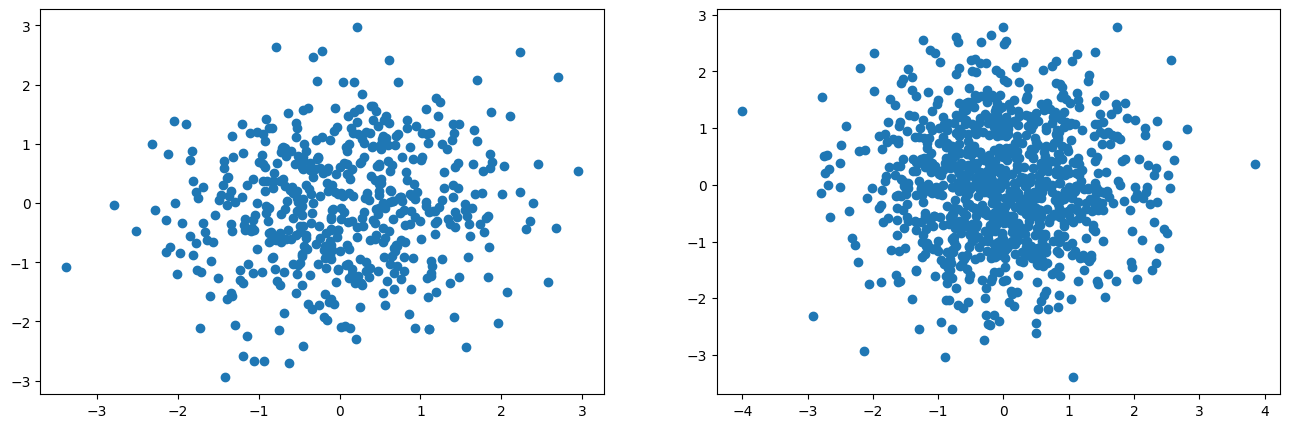

loss: 1.5963:   1%|          | 6/1000 [00:02<04:48,  3.45it/s]

negative log likelihood: 1.4185


Sampling: 100%|██████████| 100/100 [00:00<00:00, 2489.02it/s]/s]


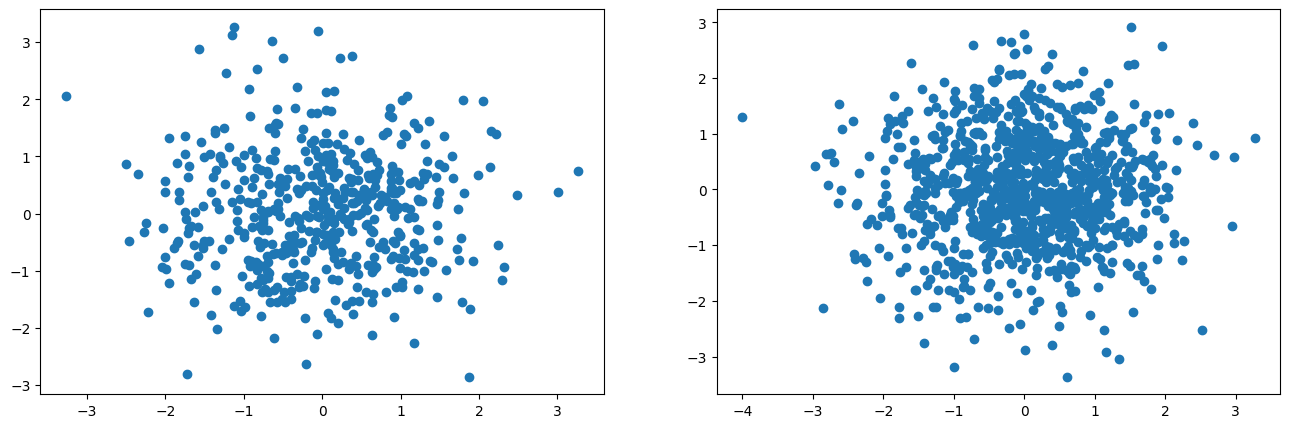

loss: 1.5355:  11%|█         | 107/1000 [00:09<02:33,  5.82it/s]

negative log likelihood: 1.4053


Sampling: 100%|██████████| 100/100 [00:00<00:00, 5119.44it/s]/s]


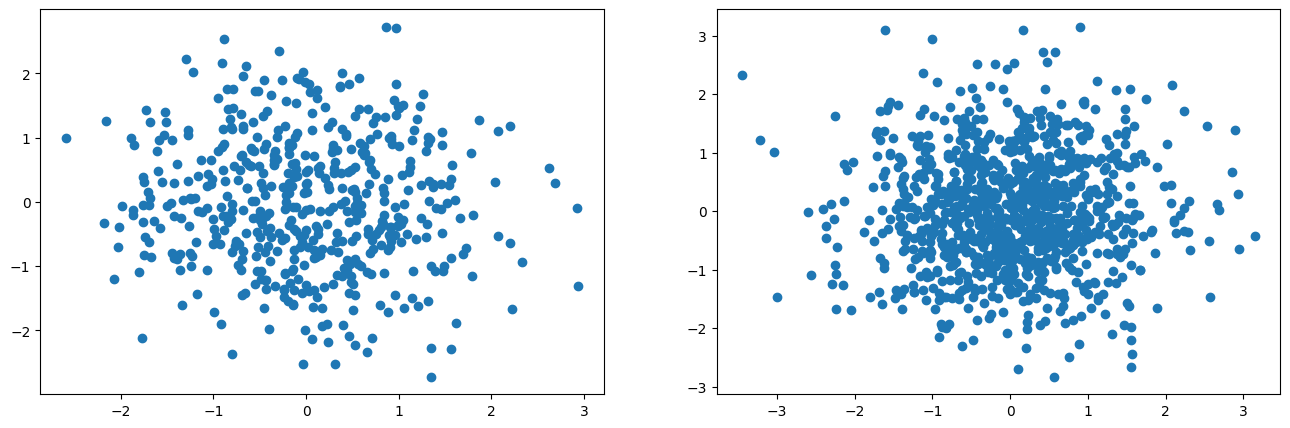

loss: 1.5480:  20%|██        | 202/1000 [00:13<01:52,  7.07it/s]

negative log likelihood: 1.4329


Sampling: 100%|██████████| 100/100 [00:00<00:00, 4365.52it/s]/s]


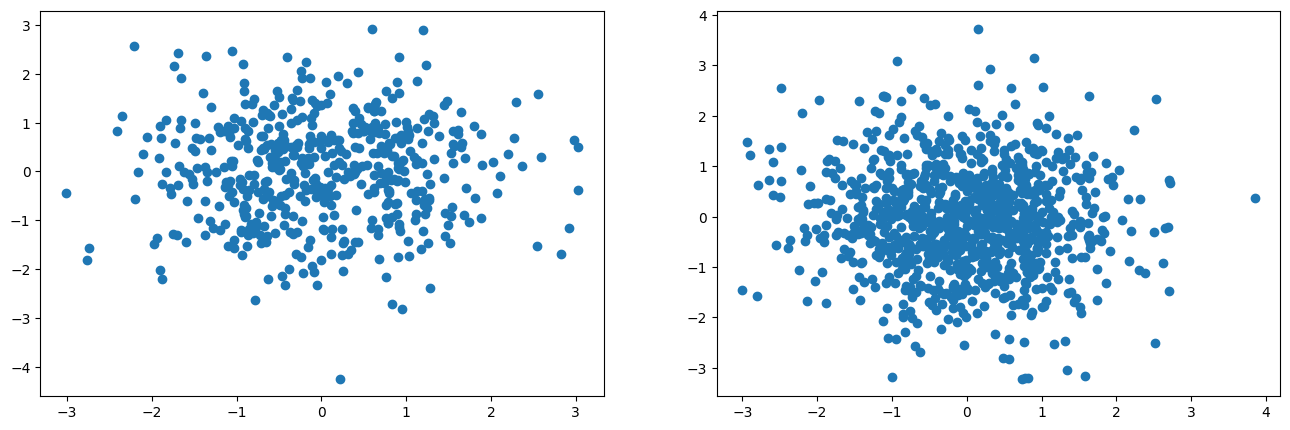

loss: 1.5582:  30%|███       | 303/1000 [00:20<02:23,  4.84it/s]

negative log likelihood: 1.3855


Sampling: 100%|██████████| 100/100 [00:00<00:00, 5455.44it/s]/s]


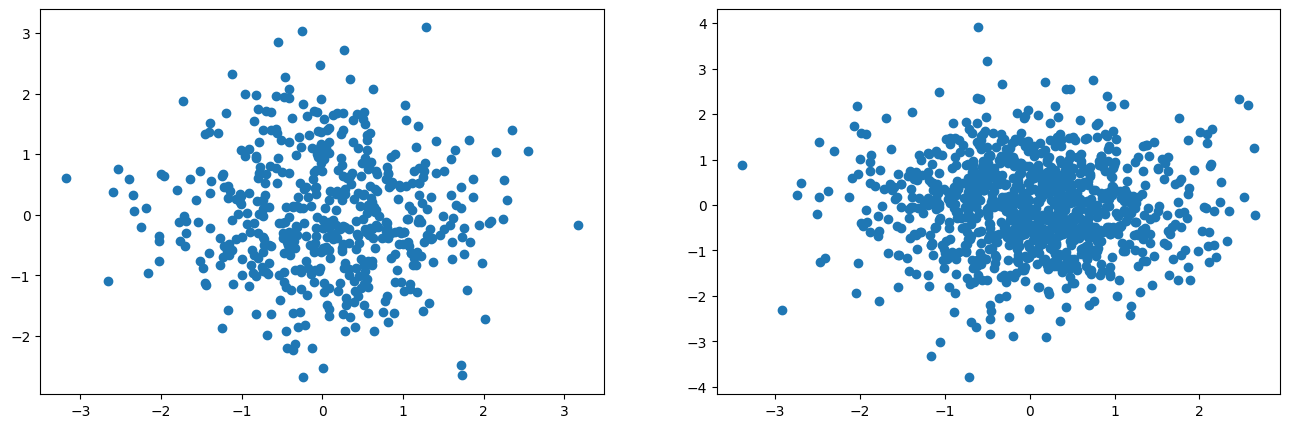

loss: 1.5627:  40%|████      | 404/1000 [00:26<01:14,  7.98it/s]

negative log likelihood: 1.4193


Sampling: 100%|██████████| 100/100 [00:00<00:00, 5876.76it/s]/s]


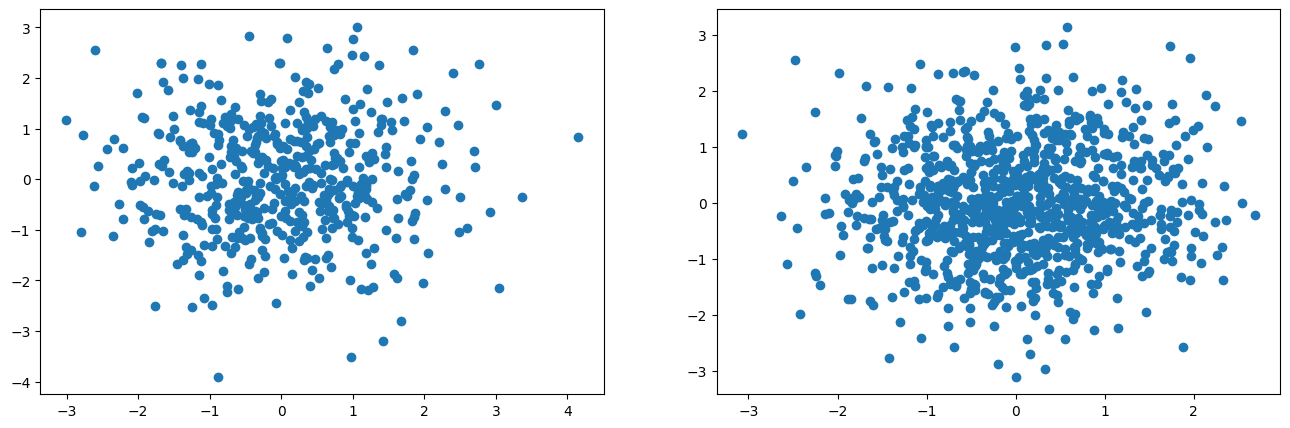

loss: 1.5852:  50%|█████     | 504/1000 [00:31<01:06,  7.46it/s]

negative log likelihood: 1.3253


Sampling: 100%|██████████| 100/100 [00:00<00:00, 5852.57it/s]/s]


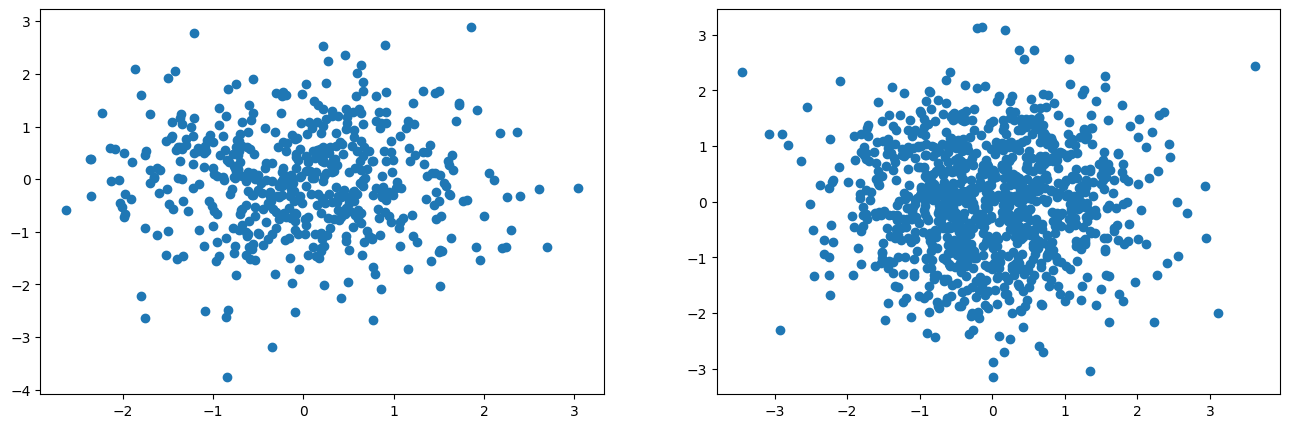

loss: 1.5907:  61%|██████    | 606/1000 [00:36<00:31, 12.70it/s]

negative log likelihood: 1.3982


Sampling: 100%|██████████| 100/100 [00:00<00:00, 5426.01it/s]/s]


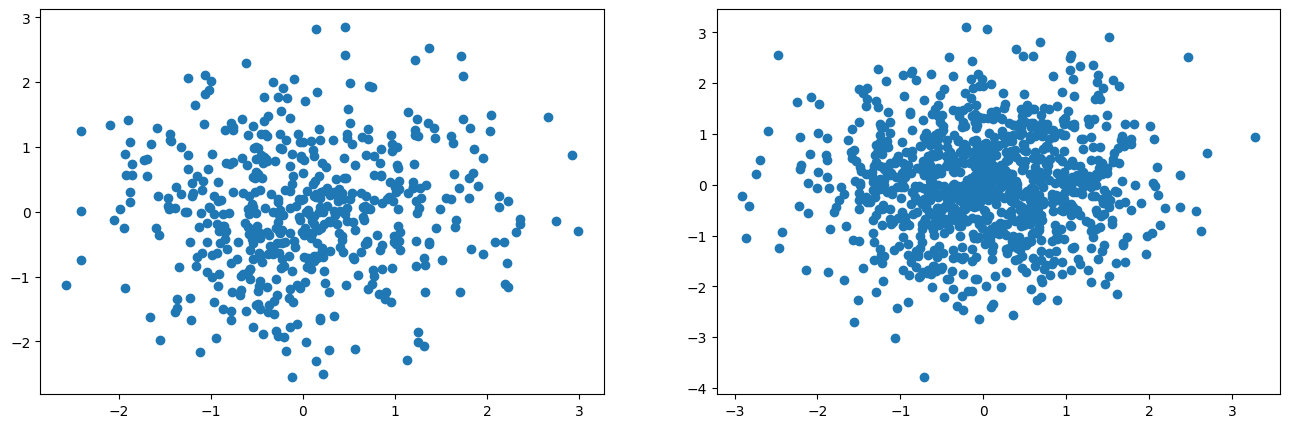

loss: 1.5671:  70%|███████   | 700/1000 [00:43<00:18, 16.08it/s]


KeyboardInterrupt: 

In [4]:
model = FM(hidden_dim=128, num_layers=4).cuda()
print('num of params:', sum(p.numel() for p in model.parameters()))
dataloader = TwoMoons().loader()
model = train(model, dataloader)

In [ ]:
model = FM(hidden_dim=128, num_layers=4, t_uncond=True).cuda()
print('num of params:', sum(p.numel() for p in model.parameters()))
model = train(model, dataloader)

num of params: 198786


NLL:  90%|█████████ | 9/10 [00:01<00:00,  4.59it/s]


KeyboardInterrupt: 